In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import pandas
import time
import json
import copy
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import cv2
import sys
import argparse

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable, Function
from torchvision import datasets, models, transforms, utils
import torchvision
import torch.nn.functional as F
import torch.nn as nn

In [31]:
image_data_transforms = {
    'training': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

In [32]:
import os
!pip install split-folders
import splitfolders

In [33]:

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.

splitfolders.ratio('/kaggle/input/flowers/flowers', output="./Data", seed=1337, ratio=(.8, .1, .1)) # default values

Copying files: 11200 files [00:21, 511.22 files/s] 


In [34]:
train_dir = '/kaggle/working/Data/train'
valid_dir = '/kaggle/working/Data/val'
test_dir = '/kaggle/working/Data/test'

batch_size = 128
training_data = torchvision.datasets.ImageFolder(train_dir, transform=image_data_transforms['training'])
validation_data = torchvision.datasets.ImageFolder(valid_dir, transform=image_data_transforms['validation'])
testing_data = torchvision.datasets.ImageFolder(test_dir, transform=image_data_transforms['testing'])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)


In [35]:
model = models.vgg19(num_classes=7,pretrained=False)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

Device: cuda:0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [38]:
num_epochs = 20
dataframe = pandas.DataFrame({
    "Epoch":pandas.Series(dtype="int"),
    "train_loss":pandas.Series(dtype="float"),
    "train_accuracy":pandas.Series(dtype="float"),
    "val_loss":pandas.Series(dtype="float"),
    "val_accuracy":pandas.Series(dtype="float")
})


for epoch in range(num_epochs):
    # Train mode
    model.train()
    train_loss = 0
    train_correct = 0
    for feature, target in train_loader:
        feature, target = feature.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(feature)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * feature.shape[0]
        train_correct += (output.argmax(1) == target).sum().item()
    train_loss /= len(training_data)
    train_accuracy = train_correct / len(training_data)

    # Validation mode
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for feature, target in validation_loader:
            feature, target = feature.to(device), target.to(device)
            output = model(feature)
            loss = criterion(output, target)
            val_loss += loss.item() * feature.shape[0]
            val_correct += (output.argmax(1) == target).sum().item()
    val_loss /= len(validation_data)
    val_accuracy = val_correct / len(validation_data)

    # Print results for this epoch
#     print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
#           .format(epoch+1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy))
    
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Val Loss: {:.4f}, Val Acc: {:.2f}%'
          .format(epoch+1, num_epochs, train_loss, train_accuracy*100, val_loss, val_accuracy*100))
    dataframe.loc[len(dataframe.index)] = [epoch+1, train_loss, train_accuracy, val_loss, val_accuracy]


Epoch [1/20], Train Loss: 1.9464, Train Acc: 13.82%, Val Loss: 1.9339, Val Acc: 14.20%
Epoch [2/20], Train Loss: 1.9372, Train Acc: 15.80%, Val Loss: 1.9247, Val Acc: 17.14%
Epoch [3/20], Train Loss: 1.9274, Train Acc: 17.24%, Val Loss: 1.9126, Val Acc: 22.59%
Epoch [4/20], Train Loss: 1.9169, Train Acc: 18.67%, Val Loss: 1.8956, Val Acc: 23.39%
Epoch [5/20], Train Loss: 1.9027, Train Acc: 20.10%, Val Loss: 1.8697, Val Acc: 26.96%
Epoch [6/20], Train Loss: 1.8743, Train Acc: 24.03%, Val Loss: 1.8209, Val Acc: 31.52%
Epoch [7/20], Train Loss: 1.8195, Train Acc: 28.76%, Val Loss: 1.7316, Val Acc: 38.93%
Epoch [8/20], Train Loss: 1.7358, Train Acc: 33.09%, Val Loss: 1.6071, Val Acc: 44.46%
Epoch [9/20], Train Loss: 1.6594, Train Acc: 36.62%, Val Loss: 1.5606, Val Acc: 43.39%
Epoch [10/20], Train Loss: 1.5591, Train Acc: 41.19%, Val Loss: 1.3934, Val Acc: 47.86%
Epoch [11/20], Train Loss: 1.4542, Train Acc: 45.21%, Val Loss: 1.3131, Val Acc: 50.54%
Epoch [12/20], Train Loss: 1.4056, Train 

In [39]:
dataframe.head()

,Epoch,train_loss,train_accuracy,val_loss,val_accuracy
0,1.0,1.946437,0.138170,1.933937,0.141964
1,2.0,1.937174,0.158036,1.924724,0.171429
2,3.0,1.927406,0.172433,1.912568,0.225893
3,4.0,1.916877,0.186719,1.895647,0.233929
4,5.0,1.902653,0.201004,1.869719,0.269643


In [40]:
import matplotlib.pyplot as plot

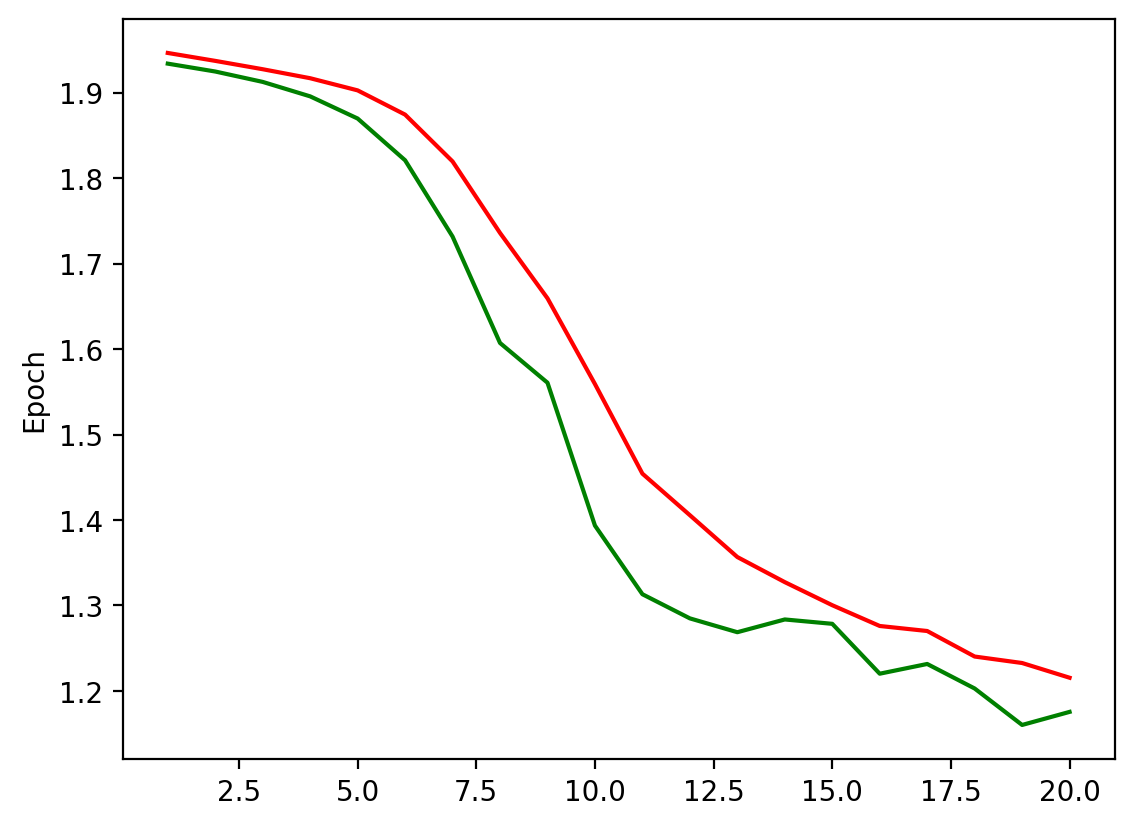

In [41]:
plot.plot(dataframe.Epoch,dataframe.train_loss,'r',label="Training Loss")
plot.plot(dataframe.Epoch,dataframe.val_loss,'g',label="Validation Loss")
plot.ylabel("Epoch")
plot.show()


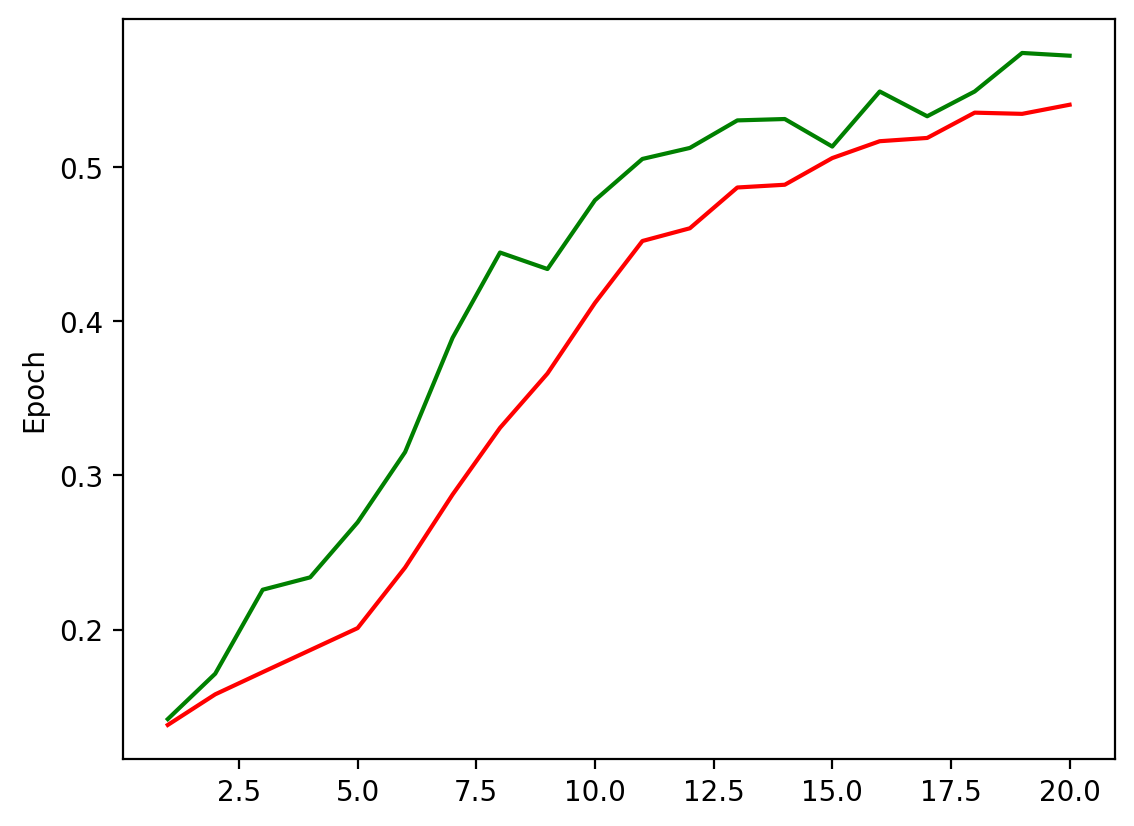

In [42]:
plot.plot(dataframe.Epoch,dataframe.train_accuracy,'r',label="Training Accuracy")
plot.plot(dataframe.Epoch,dataframe.val_accuracy,'g',label='Validation Accuracy')
plot.ylabel("Epoch")
plot.show()

In [43]:
# Print summary information.
# total_time = time.time() - start_time
# print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
# print('Best validation accuracy: {:.4f}'.format(best_val_accuracy))

In [44]:
model.eval()  # set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test accuracy: %d %%' % (100 * correct / total))

Test accuracy: 56 %


In [45]:
torch.save(model, f"VGGNet.pth")
# pickle.dump(train_results, open(f"train_results.pkl", "wb"))

In [46]:
class_names = training_data.classes
class_names

['bellflower', 'daisy', 'dandelion', 'lotus', 'rose', 'sunflower', 'tulip']

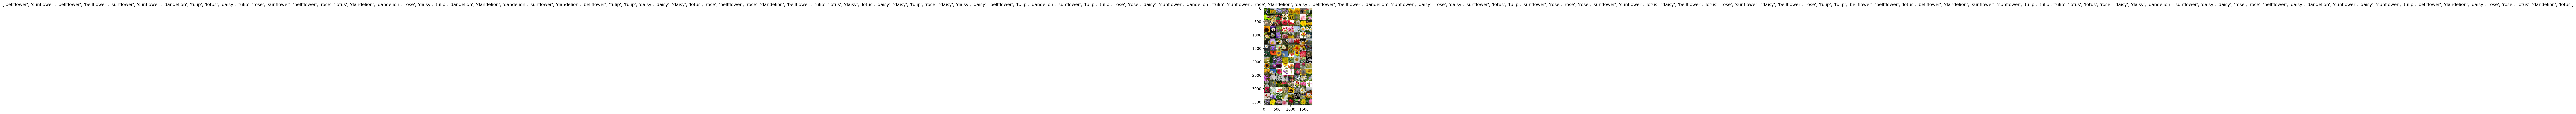

In [47]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

#Analysis after Model Training


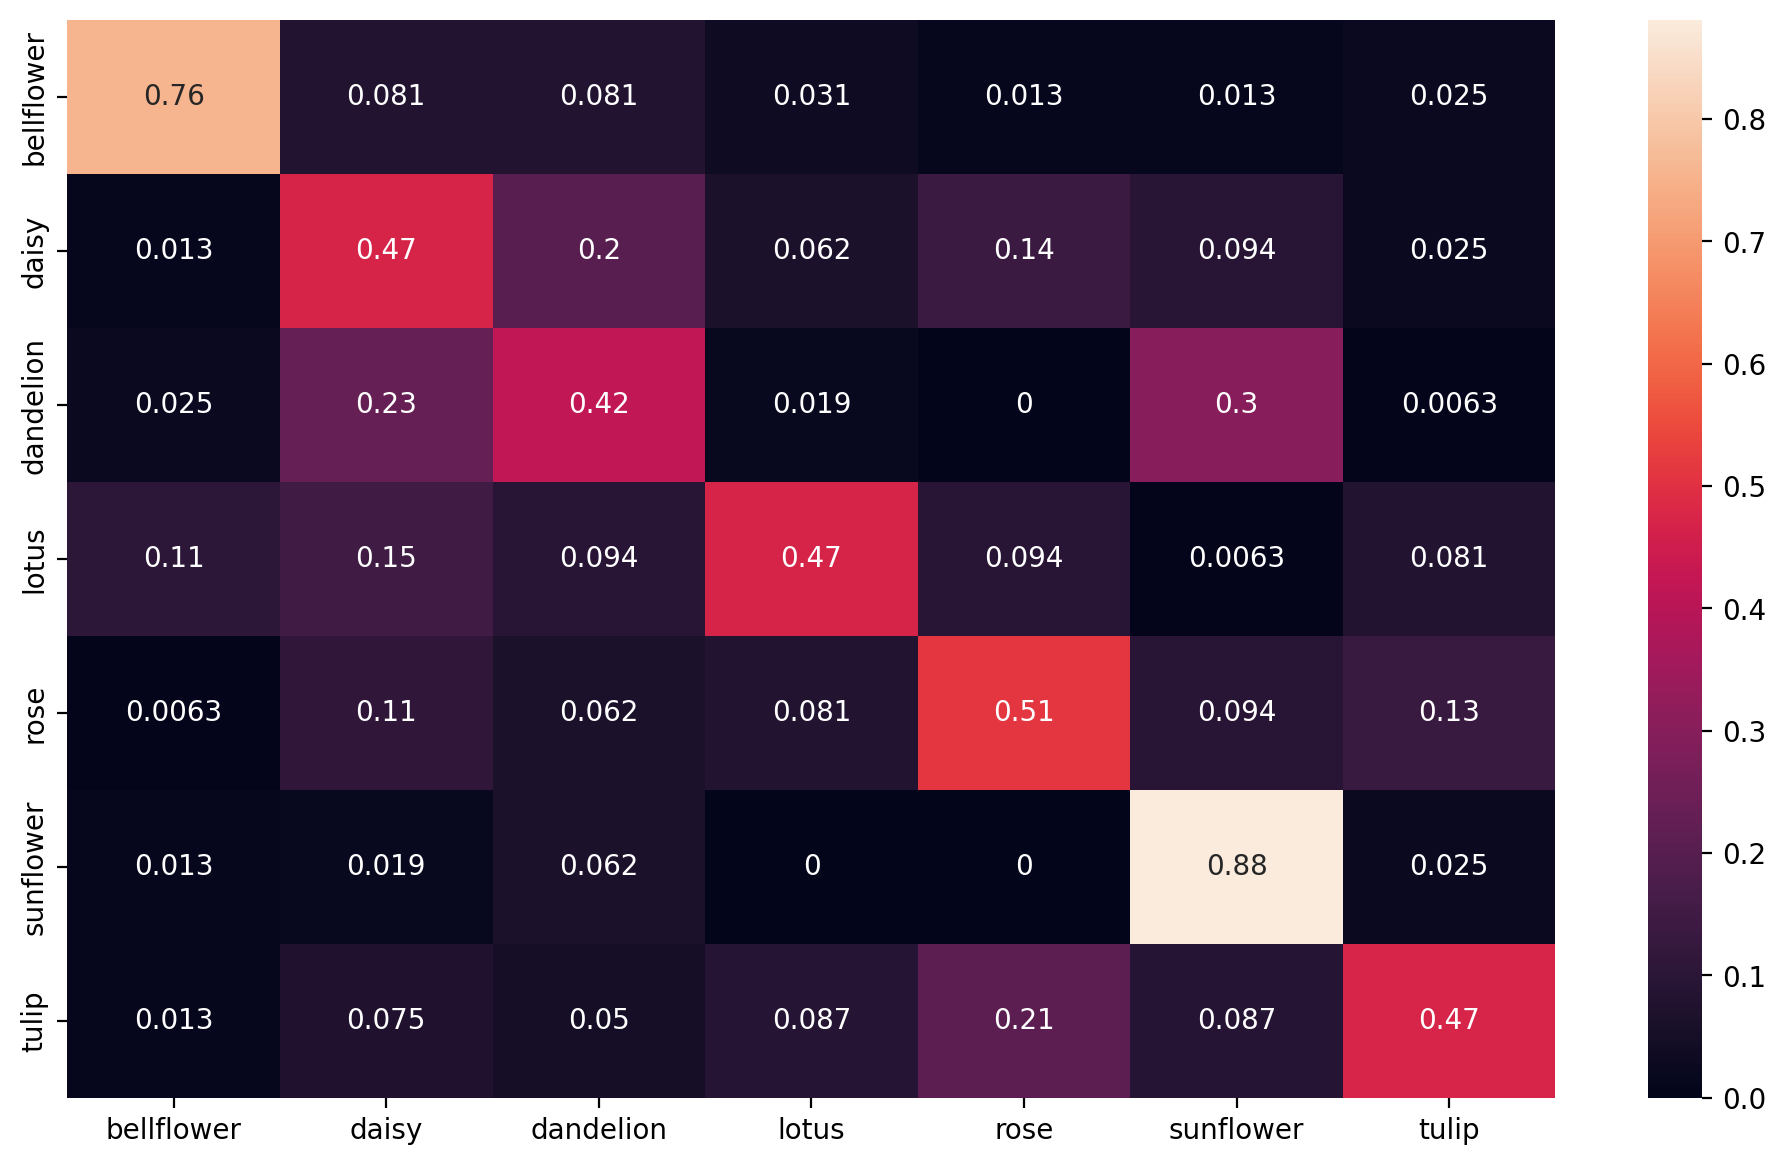

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
# class_names = testing_data.classes


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [49]:
from sklearn.metrics import accuracy_score, classification_report

# print accuracy
print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")

# print precision, recall, F1-score per each class/tag
print(classification_report(y_true, y_pred,target_names=training_data.classes))

Overall Accuracy:  56.88  %
              precision    recall  f1-score   support

  bellflower       0.81      0.76      0.78       160
       daisy       0.41      0.47      0.44       160
   dandelion       0.43      0.42      0.43       160
       lotus       0.62      0.47      0.54       160
        rose       0.53      0.51      0.52       160
   sunflower       0.60      0.88      0.71       160
       tulip       0.62      0.47      0.54       160

    accuracy                           0.57      1120
   macro avg       0.58      0.57      0.56      1120
weighted avg       0.58      0.57      0.56      1120

